<a href="https://colab.research.google.com/github/AnnaBobasheva/KG-R/blob/main/Jupyter_R_notebook_querying_WeKG_dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with meteorological data knowlege graph - WeKG-MF 
#### maintaned by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstartes how to access and query WeKG-MF RDF dataset and apply classification methods to the query results. 

The WeKG dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions. 

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo. 

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

In this notebook we are going to explore how can use weather data and statistical models to classify wine growing regions and grape varieties.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Winkler, Albert Julius. General viticulture. Univ of California Press, 1974. Book.

Jones, Gregory V., Andrew A. Duff, Andrew Hall, and Joseph W. Myers. "Spatial analysis of climate in winegrape growing regions in the western United States." American Journal of Enology and Viticulture 61, no. 3 (2010): 313-326. https://researchoutput.csu.edu.au/ws/portalfiles/portal/8768033/postpubPID19814.pdf

Van Leeuwen, CornelIs, C. Garnier, C. Agut, Bernard Baculat, Gerard Barbeau, E. Besnard, B. Bois et al. "Heat requirements for grapevine varieties is essential information to adapt plant material in a changing climate." In 7. Congrès International des Terroirs Viticoles. 2008. https://hal.inrae.fr/hal-02758537/file/28929_20110210031815860_1.pdf





In [ ]:
R.Version()$version

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

## Setup


NOTE: If you are runing this notebook in Google Colab it may take a long time to install some packages. At the moment we didn't find a remedy to this. Please be patient, have a cup of cofee or play [Wordle](https://www.nytimes.com/games/wordle/index.html)

### Enable quering of the Knowledge Graph  
The easiest way to access and query the dataset endpoint is to use the R package [SPARQL](https://cran.r-project.org/web/packages/SPARQL/index.html). However, it was recently removed from the CRAN repository but still can be installed from the archive. 

Alternatively, use this work: https://ourednik.info/maps/2021/12/14/execute-sparql-chunks-in-r-markdown/ .

In [ ]:
options(warn=-1) # to turn warning back on use options(warn=0)

# The package SPARQL was removed from CRAN in May, 2022. 
# To be able to use it it we need to install its prerequisites 
# and then install it from archive
if (!require(SPARQL)) {
  install.packages("XML", quiet=TRUE)
  install.packages("RCurl", quiet=TRUE)
  install.packages("https://cran.r-project.org/src/contrib/Archive/SPARQL/SPARQL_1.16.tar.gz",
                    repos=NULL, type="source",  quiet=TRUE)
}
library(SPARQL)  

Loading required package: SPARQL

also installing the dependency ‘bitops’


Loading required package: XML

Loading required package: RCurl



### Define dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environmet an *https* endpoint URL may lead to an error. In this case try to change to *http*.

In [ ]:
endpoint <- "http://weakg.i3s.unice.fr/sparql"
options <- NULL

### Define prefixes to abbreviate namespaces

The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

In [ ]:
sparql_prefix <- '
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX geosparql:  <http://www.opengis.net/ont/geosparql#> 
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX weo: <http://ns.inria.fr/meteo/ontology/>
PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
PREFIX wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/>
PREFIX wes-dimension: <http://ns.inria.fr/meteo/observationslice/dimension#>
PREFIX wes-measure: <http://ns.inria.fr/meteo/observationslice/measure#>
PREFIX wes-attribute: <http://ns.inria.fr/meteo/observationslice/attribute#>
'

data_prefix <- c('wekg','<http://ns.inria.fr/meteo/>', 
                 'wevp', '<http://ns.inria.fr/meteo/vocab/weatherproperty/>',
                 'wd',   '<http://www.wikidata.org/entity/>',
                 'wdt',  '<http://www.wikidata.org/prop/direct/>',
                 'qudtu', '<http://qudt.org/vocab/unit/>')

### Enable modeling packages

In this notebook we'll be using libraries that allow easy way to train and test various classification models:

- *kmeans*, *prcomp*, and *glm* methods are from the installed by default `stats` library are used to performs k-means clustering, principal component analysis, and fit generalized linear models respectively

- `rpart` is a a powerful machine learning library in R that is used for building classification and regression trees

- `caret` contains functions to streamline the model training process for complex regression and classification problems.



In [ ]:
if (!require(rpart. , quietly=TRUE)){
  install.packages("rpart", quiet = TRUE)
}
library (rpart)

# Load the required library
if (!require(caret. , quietly=TRUE)){
  install.packages("caret", quiet = TRUE)
}
library(caret)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice



### Enable visualisation tools
For the charting the data we will be using a popular packages: 
- `gglpot2` that will allow to create graphs that represent both univariate and multivariate numerical and categorical data

- `factoextra` for cluster visualization

- `rpart.plot` for plotting decision trees

- `ggvenn` for ploting Venn diagram

In [ ]:
library(ggplot2)

#if (!require("RColorBrewer")) install.packages("RColorBrewer")
#library(RColorBrewer)

if (!require("factoextra"))  install.packages("factoextra")
library(factoextra )
#library(gridExtra)
#library(viridis)

if (!require("rpart.plot")) install.packages("rpart.plot")
library(rpart.plot)

if (!require(ggvenn)) install.packages("ggvenn")
library(ggvenn)

### Enable data manipulation tools

We also need some data manipulation tools that makes lide easier:
- for filling NA fields we can use *na.fill* method in the `zoo` library

- another very handy *melt* method comes from `reshape2` library

In [ ]:
#for na.fill
if (!require(zoo, quietly=TRUE)) {
    install.packages("zoo" , quiet = TRUE)
}
library(zoo)

#for melt
if (!require(reshape2, quietly=TRUE)) {
    install.packages("reshape2" , quiet = TRUE)
}
library(reshape2)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Preparing the dataset

**GDD**, Growing Degree Days, is a measure of heat accumulation used by viticulturists (cultivator of grape vine) to assess the growth and development of grapevines. It is calculated by taking the average daily temperature, subtracting a base temperature (usually 10°C), and then summing the resulting values over the course of the season (April to September in the nothern hemisphere).

**GST**, Growing Season Temperature, can provide another bioclimatic index for identifying regions of cool and very cool climates. GST is calculated by avraging the average dayly temperature over the course of the growing season.

**Rainfall** is the amount of liquid precipitation (rain, sleet, snow, etc.) that falls from the sky over a given period of time. Viticulturists use rainfall data to assess the moisture levels in the soil and to determine if irrigation is necessary. The cumilative rainfall is calculated from January to October in nothern hemisphere.

We can calculate GDD, GST and rainfall in a query. For simplicity reasons we only consider the weather stations from the Nothern hemisphere. 

In [ ]:
query_GDD_rainfall  <- '
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT (SAMPLE(STR(?regionLabel)) as ?region) 
       ?station ?stationName 
       ?year
	     (AVG(?lat) as ?lat) 
	     (AVG(?long) as ?long) 
       (AVG(?alt) as ?alt) 

       (SUM(?gdd) as ?GDD) 
       (AVG(?temp_avg) as ?GST)
       (SUM(?precipitation) as ?rainfall)
       (SUM(?precip_daily) as ?rainfall_slice)

WHERE
{
  ?station rdfs:label ?stationName;
           geo:lat ?lat; 
           geo:long ?long;
           geo:altitude ?alt.
             
  OPTIONAL {?station dct:spatial/wdt:P131 ?region.
            ?region rdfs:label ?regionLabel;
                    wdt:P2585 ?regionCode.}
  {  
        ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
           wes-attribute:observationDate ?date ;
           wes-measure:avgDailyTemperature ?temp_avg]

           BIND( IF( ?temp_avg > 10 , ?temp_avg - 10, 0)  as ?gdd)
           FILTER  ( MONTH(?date) > 3 && MONTH(?date) < 11)
   }
UNION

  {  
        ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
                           wes-attribute:observationDate ?date ;
                           wes-measure:rainfall24h ?precip_daily]

           FILTER  ( MONTH(?date) < 11)
   }

UNION 
{
  ?obs a weo:MeteorologicalObservation;
       sosa:observedProperty wevp:precipitationAmount;
       sosa:hasSimpleResult ?precipitation;
       sosa:phenomenonTime [ a weo:Interval24h ];
       sosa:resultTime ?datetime;
       wep:madeByStation ?station. 
    
    BIND (xsd:date(SUBSTR(STR(?datetime), 1,10)) as ?date)
    FILTER (CONTAINS (STR(?datetime), "T00:00:00" ))
    FILTER  ( MONTH(?date) < 11)
  } 

  BIND(YEAR(?date) AS ?year )

  FILTER (?lat > 0) # only northern hemisphere
}

GROUP BY ?station ?stationName ?year 
ORDER BY ?stationName ?year 
'

query_GDD_rainfall <- paste(sparql_prefix, query_GDD_rainfall)

GDD_rainfall <- SPARQL(url= endpoint,
              query = query_GDD_rainfall,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(GDD_rainfall)))

[1] "Result rows: 311"


In [ ]:
# Fill the blanks in rainfall and region columns
GDD_rainfall$rainfall <- na.fill(GDD_rainfall$rainfall, 0)
GDD_rainfall$region <- ifelse(is.na(GDD_rainfall$region) , GDD_rainfall$stationName, GDD_rainfall$region)

# Do not consider rows with other blanks
GDD_rainfall <- na.omit(GDD_rainfall)

#### Class assignment 1 (WInkler Index)


The Winkler Index is a technique for classifying the climate of wine growing regions based on heat summation or GDD. In the system, geographical areas are divided into five climate regions based on temperature converted to growing degree-days, and is commonly known as Regions I–V.

We can use the calculated GDD value to classify the geographical locations into different wine groing regions. For example, you might use the following GDD ranges to classify French wines:

- GDD less that 850: Too cool 

- Region I: GDD 850 to 1389 : Wines made from cool-climate grape varieties, such as Chardonnay, Sauvignon Blanc, Pinot Noir, and Riesling. These wines tend to be light-bodied and crisp, with fresh acidity and delicate flavors. Typical French regions: Champagne, Rhin, Moselle, Bourgogne, Vallée de la Loire , Savoie, city of Bordeaux.

- Region II: GDD 1389 to 1667: Wines made from grape varieties that thrive in moderate climates, such as Syrah, Merlot, and Cabernet Sauvignon. These wines tend to have medium-bodied, fruity flavors and medium to high tannins. Typical French regions: Bordeaux.

- Region III: GDD 1667 to 1944: Wines made from warm-climate grape varieties, such as Grenache, Carignan, and Mourvèdre. These wines tend to be full-bodied, with ripe, bold flavors and high alcohol levels. Typical French regions: Nothern Rhône

- Region IV: GDD 1944 to 2222: Favorable for high production, but acceptable table wine quality at best. Typical French regions: Languedoc, Roussillon, South Rhone, and Corsica.

- Region V: GDD 2222 to 2700: Typically only suitable for extremely high production, fair quality table wine or table grape varieties destined for early season consumption are grown. Not applicable to France.

- GDD greater than 2700: Too hot


NOTE that this is just one possible way to classify French wines based on GDD and is used here just for the demonstartion.
http://passion.vignobles.free.fr/section_vignes/Les%20besoins%20agro-climatiques.php

In [ ]:
winkler_labels=c("Too cool", "Region I", "Region II", "Region III", "Region IV", "Region V", "Too hot" )

winkler <- function(gdd) {
    if (gdd <= 850) {  return (1)
    }  else if (gdd> 850  & gdd  <= 1389) { return (2)
    }  else if (gdd> 1389 & gdd  <= 1667) { return (3)
    }  else if (gdd> 1667 & gdd  <= 1944) { return (4)
    }  else if (gdd> 1944 & gdd  <= 2222) { return (5)
    }  else if (gdd> 2222 & gdd  <= 2700) { return (6)
    }  else { return (7) }
}

GDD_rainfall$winkler_class <- factor(sapply(GDD_rainfall$GDD , winkler), labels=winkler_labels, ordered=TRUE)

#### Class assignement 3 (GST) - perhaps delete this section too

https://researchoutput.csu.edu.au/ws/portalfiles/portal/8768033/postpubPID19814.pdf



In [ ]:
avgGST_labels=c("Too cool", "Cool", "Intermediate", "Warm", "Hot", "Very hot", "Too hot" )

avgGST <- function(gst) {
    if (gst < 13) {  return (1)
    }  else if (gst>= 13 & gst  < 15) { return (2)
    }  else if (gst>= 15 & gst  < 17) { return (3)
    }  else if (gst>= 17 & gst  < 19) { return (4)
    }  else if (gst>= 19 & gst  < 21) { return (5)
    }  else if (gst>= 21 & gst  < 24) { return (6)
    }  else { return (7) }
}

GDD_rainfall$gst_class <- factor(sapply(GDD_rainfall$GST ,avgGST), labels=avgGST_labels, ordered=TRUE)


## Unsupervised classification

We'd like to see if there is a way to group the weather stations based on their bioclimatic variables GDD and rainfall.

As the number of clusters we select the same number as winckler classes (7). If we are lucky they may align. 

For visualization reasons we minimize the number of data points by averaging the bioclimatic values over the years for each weather station.

In [ ]:
# Create a data frame with values averaged over the years for each station
group_by <- list( region = GDD_rainfall$region,
                  stationName = GDD_rainfall$stationName,
                  lat = GDD_rainfall$lat, 
                  long = GDD_rainfall$long,
                  alt = GDD_rainfall$alt  )
GDD_rainfall.avg <-aggregate(GDD_rainfall[, c("GDD", "GST", "rainfall")], by = group_by, mean)

#GDD_rainfall.avg[order(GDD_rainfall.avg$GDD, decreasing = TRUE), ]

### K-means cluster analysis

https://uc-r.github.io/kmeans_clustering

In [ ]:
GDD_rainfall.km <- GDD_rainfall.avg[, c("GDD", "rainfall")]

# perform cluster analysis
set.seed(42)
k <- 7
km <- kmeans(scale(GDD_rainfall.km), k)

# view the cluster assignments for each data point
#print(km)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


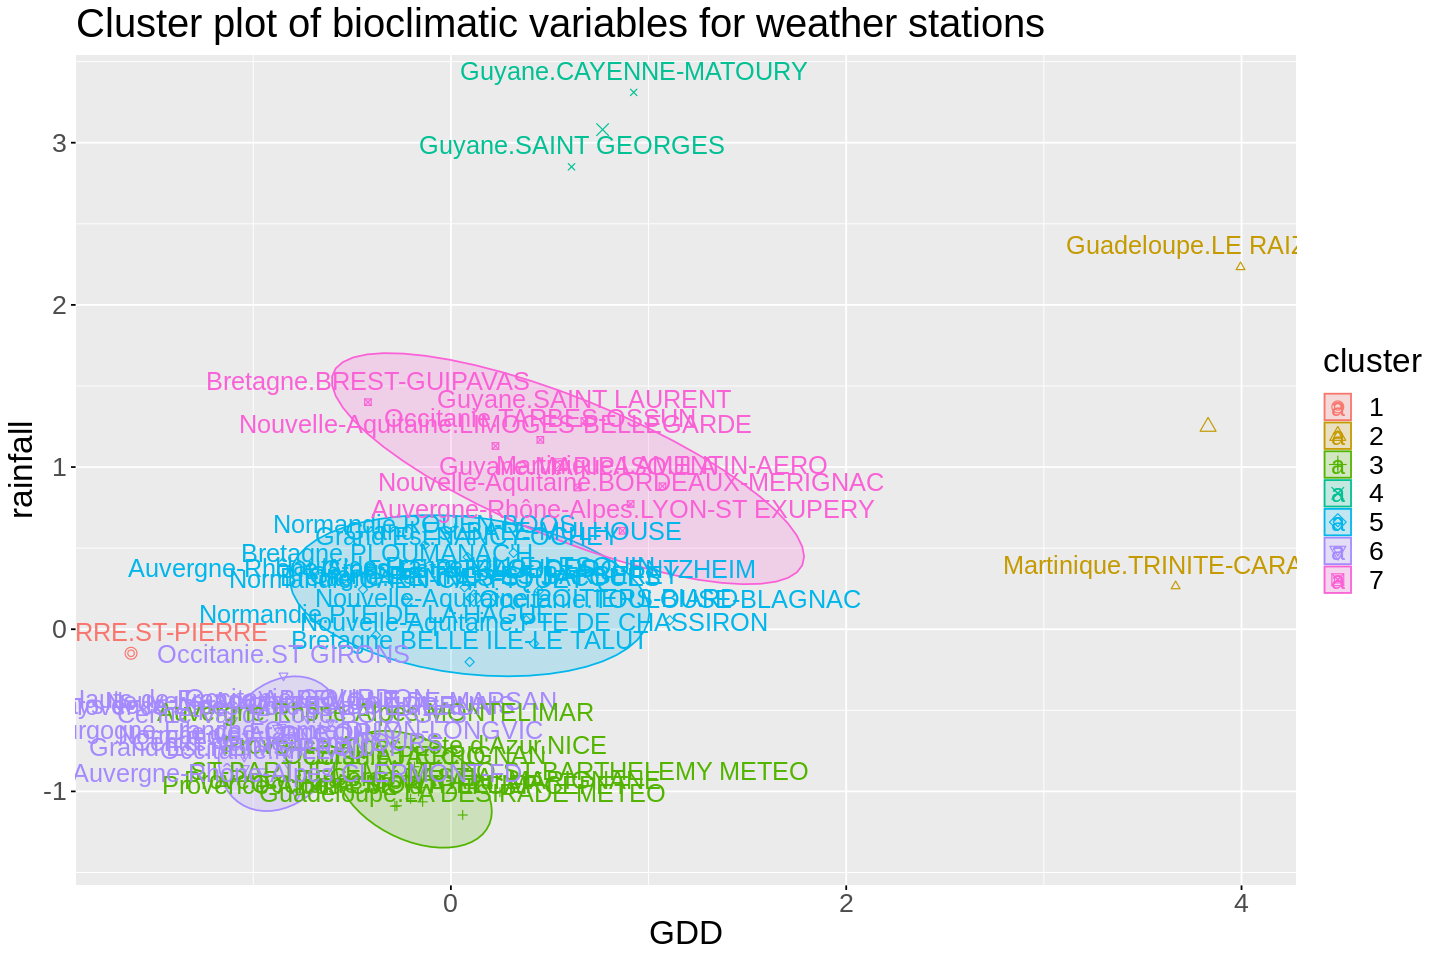

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

rownames( data = GDD_rainfall.km) <- paste( GDD_rainfall.avg$region, GDD_rainfall.avg$stationName,  sep="." )

fviz_cluster(km, data = GDD_rainfall.km,
             main="Cluster plot of bioclimatic variables for weather stations",
             labelsize=16,
             ellipse.type = "t", 
             #ggtheme = theme(legend.title = element_text(size = 20, face = "bold"),
             #                legend.text = element_text(size = 20),) 
             ggtheme = theme(text = element_text(size = 20),) 
             ) 

#### Compare clustering and Winkler index classes 

Let's see if the Wincler regions and clusters are aligned by plotting a bar plot where the bars correspond to each cluster and the height of the bar represents the number of stations in the cluster and the color represents the Winckler index of counted station.

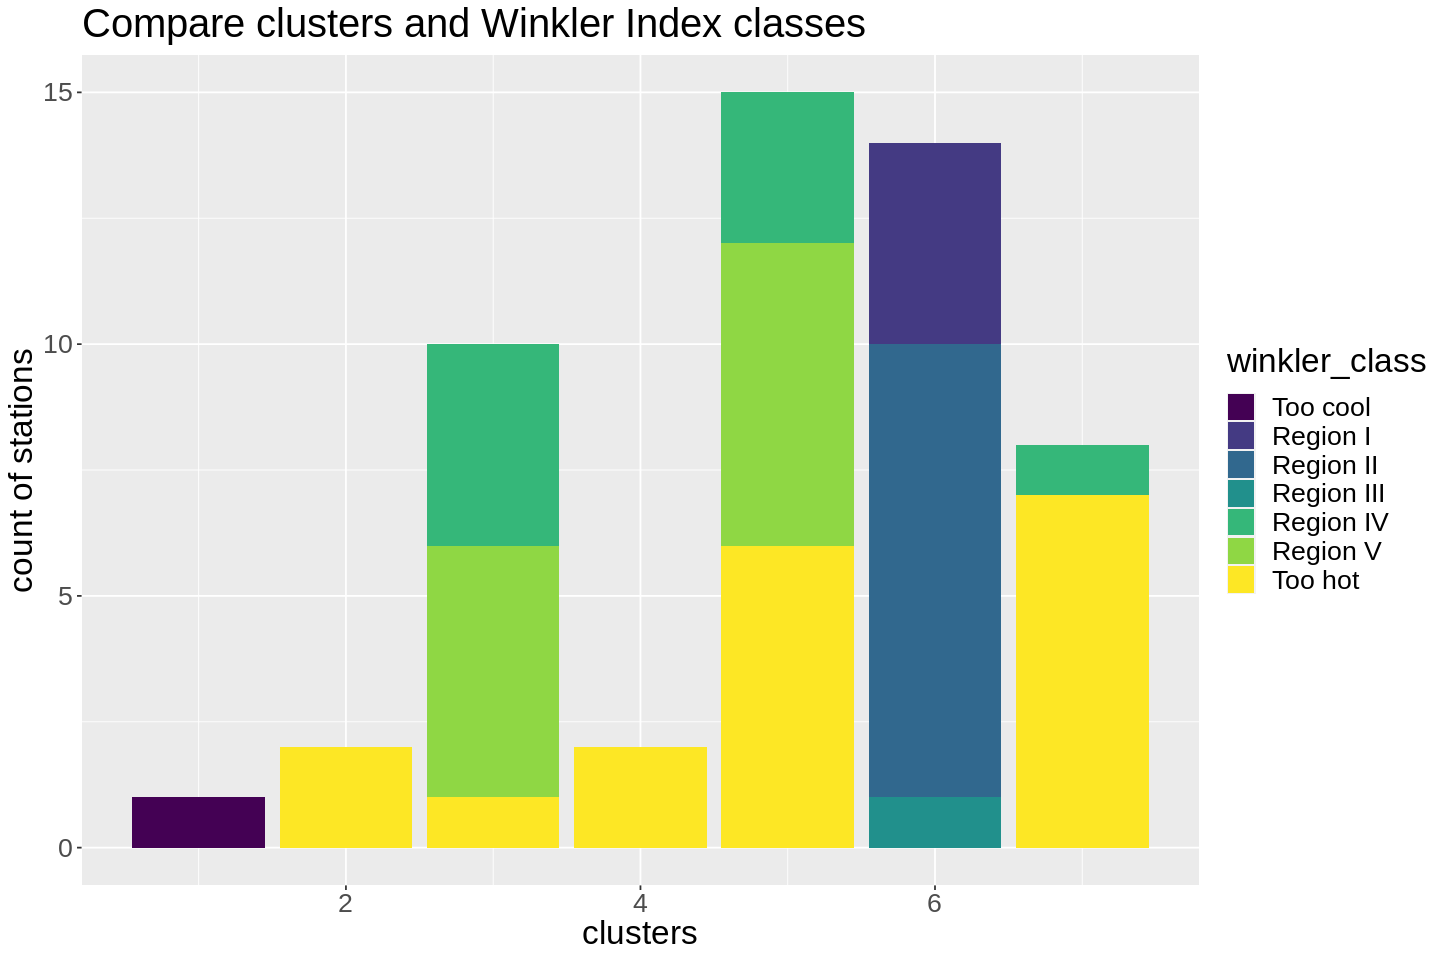

In [ ]:
# Compare clustering  and GDD thresholding 
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

GDD_rainfall.avg$cluster <- km$cluster
GDD_rainfall.avg$winkler_class <- ordered(sapply(GDD_rainfall.avg$GDD, winkler), labels= winkler_labels)

ggplot(GDD_rainfall.avg, aes(x=cluster, fill=winkler_class)) + 
      geom_bar(position = "stack")  +
      theme(text = element_text(size = 20),) +
      ggtitle("Compare clusters and Winkler Index classes") +
      xlab("clusters") +
      ylab("count of stations") 

In [ ]:
# show the stations in the cluster number cn
cn <- 3
GDD_rainfall.avg[GDD_rainfall.avg$cluster == cn, c("region", "stationName", "cluster", "winkler_class")]

CONCLUSION:
- k-means clustering was able to identify the outlier with too cool climate for wine making - Saint-Pierre island near Canada
- as well as too hot areas of the Caribbeans, Guyane, Guadelupe and Martinique
- it also put the typical French wine growing regions (I,II, III) into one cluster meaning that all wine growing regions are somewhat similar to each other in their GDD and rainfall. In short we can call this cluster a cluster of wine producing regions.
- it also shows that the hot and humid areas are diverse in their climate parameters.


#### Visualize regions sets based on clusters

Let's put the regions of the stations from the claster "wine producing areas" in one set and the regions of other stations in another. We can plot the sets on Venn diagram and see how they are intersect.

In [ ]:
wine_regions <- unique(GDD_rainfall.avg[GDD_rainfall.avg$cluster == 6, c("region")])
no_wine_regions <- unique(GDD_rainfall.avg[GDD_rainfall.avg$cluster != 6, c("region")])

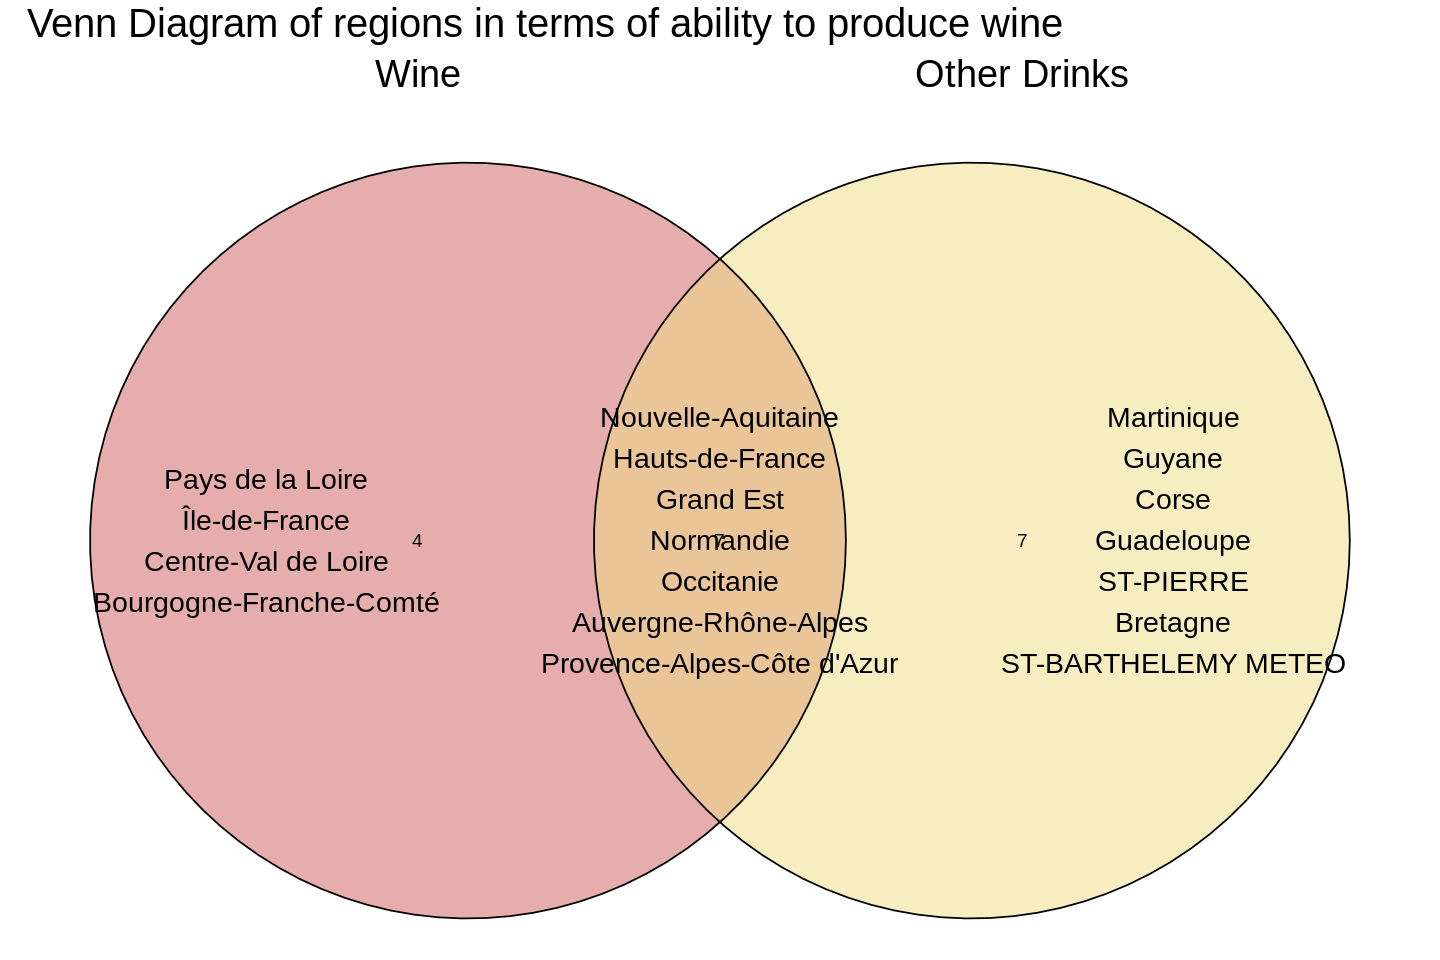

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

sets <- list(
  "Wine" = wine_regions, 
  "Other Drinks" = no_wine_regions 
  )

w <- paste(setdiff(wine_regions, no_wine_regions), collapse="\n")
i <- paste(intersect(wine_regions, no_wine_regions), collapse="\n")
o <- paste(setdiff(no_wine_regions, wine_regions), collapse="\n")

#library(ggvenn)
ggvenn( sets, fill_color = c("indianred", "lightgoldenrod"),
           stroke_size = 0.5, set_name_size = 8 ,
           show_elements = FALSE,
           show_percentage  = FALSE ) +
      theme(text = element_text(size = 20),) +
      ggtitle("Venn Diagram of regions in terms of ability to produce wine") +
      annotate("text", x= c(-1.2, 0, 1.2), y=0, label= list(w, i, o), size=6) 


CONCLUSION: 

- the separatoin of the regions is very close to real life
- regions where wine grapes grows everywhere are identified e.g. Bourgogne or Loir Valley
- regions with too hot and too cold weather e.g Martinique or Saint-Barthelemy island
- and all the other in between  
- one real mistake is Corsica as it is known for its wine

## Principal Component Analysis 

We can combine bioclimatic and geospatial variables of wine growing regions and analyse if there is any correlation between them.


In [ ]:
GDD_rainfall_wine <- GDD_rainfall[GDD_rainfall$region %in% wine_regions, ] 

Standard deviations (1, .., p=6):
[1] 1.3918574 1.2750487 1.1545143 0.9410202 0.4016277 0.2392841

Rotation (n x k) = (6 x 6):
                PC1         PC2         PC3         PC4        PC5        PC6
long      0.2703167  0.09074881 -0.45098188  0.79968532 -0.1790025 -0.2092137
lat      -0.5682915  0.05414711  0.27327777  0.52718672  0.2304065  0.5180918
alt      -0.1181335  0.13947311 -0.80282496 -0.25403860  0.3154399  0.3975246
GDD       0.1331746 -0.73849926 -0.02320917  0.12219366  0.6271205 -0.1677297
GST       0.6846170 -0.12369775  0.16677654  0.03318009 -0.1068822  0.6896806
rainfall -0.3218418 -0.63929469 -0.22148048 -0.04483011 -0.6408312  0.1612208

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6
Standard deviation     1.3919 1.2750 1.1545 0.9410 0.40163 0.23928
Proportion of Variance 0.3229 0.2710 0.2221 0.1476 0.02688 0.00954
Cumulative Proportion  0.3229 0.5938 0.8160 0.9636 0.99046 1.00000

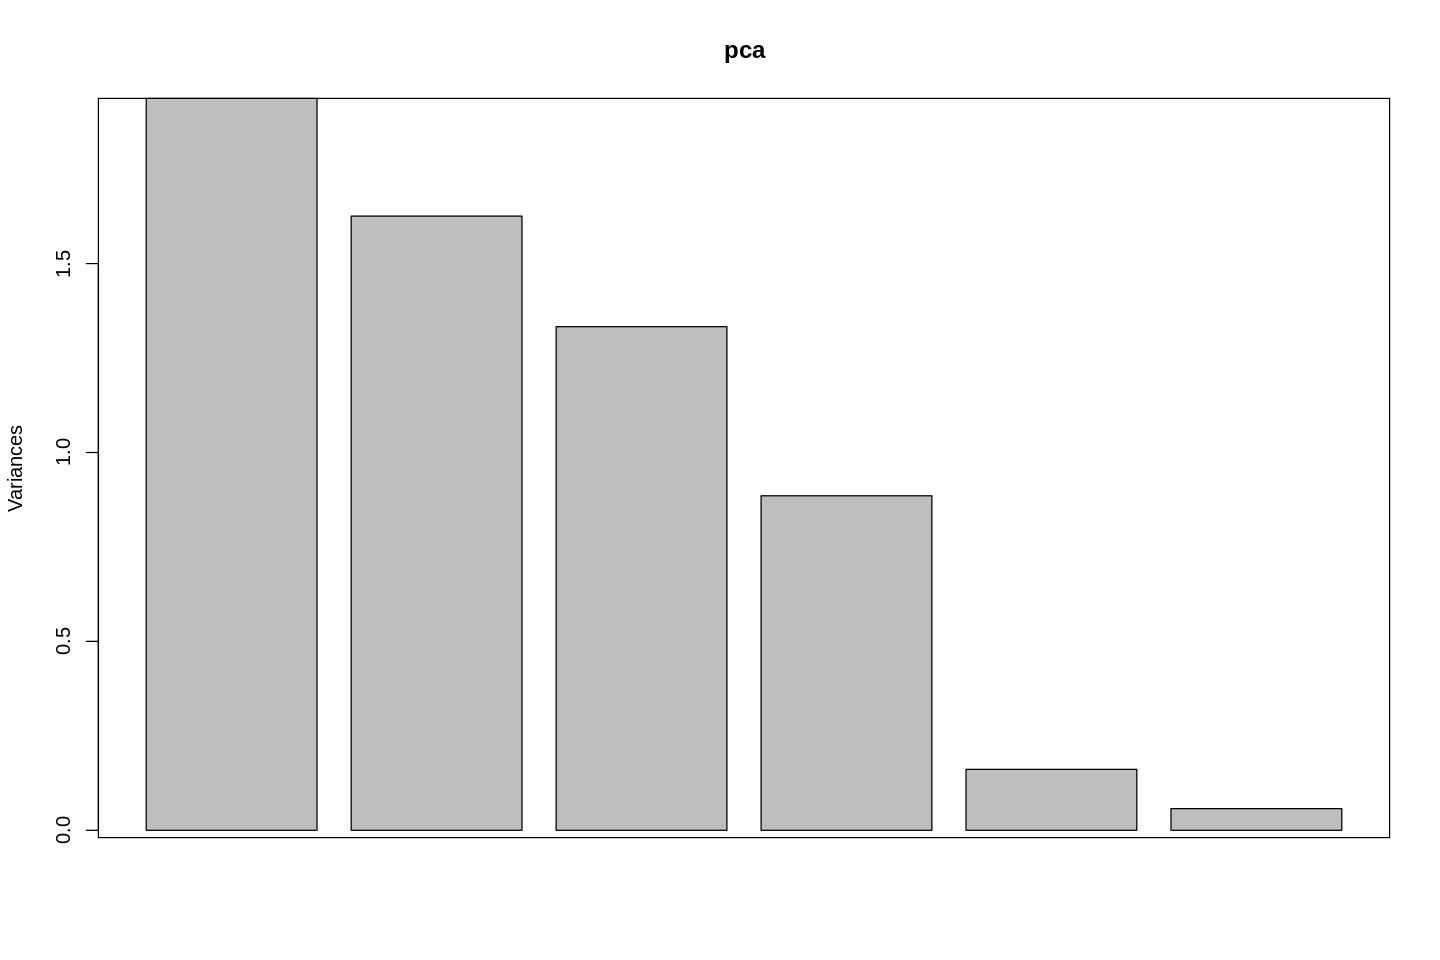

In [ ]:
GDD_rainfall.pca <- GDD_rainfall_wine[, c( "long", "lat", "alt", "GDD", "GST", "rainfall")]

pca <- prcomp(GDD_rainfall.pca , center=TRUE,  scale.=TRUE)

pca

summary(pca)

screeplot(pca)
box()

CONCLUSIONS:

The first principal component (PC1) explains the most variance in the data, the second principal component (PC2) explains the second most variance, and so on. The loading of the eigenvector represent how important each original variable to the component.

Additionally, we can also observe the explained variance by each component, which tells us how much of the total variance in the data is explained by each component. This can be used to decide how many components to keep in the analysis, for example if we see that first three components explain over 80% of total variance, then we might consider to keep only these three components.

- PC1 has a large positive loading on GST and a large negative loading on latitude, which indicates that the temperature and latitude are negatively correlated and that they explain ~30% of the variation in the data

- PC2 has negative loading on *GST* and *rainfall*, it might indicate that GDD   and *rainfall* are positively correlated and they explain another ~30% of variation in the data

- PC3 has strong negative loading on *altitude* which means that it explains another portion of variance and brings cumulative proportion of explained variance to ~80%

- looks like we can reduce our data dimentionality in half if we need to 


## Supervised classification

For the classificaton let's consider only the wine making regions only. 

Previously we already annottaed the weather stations with Winkler index classes based on the GDD. 

In addition we did some research on viticulture in tha areas surrounding the weather stations. Based on this research we can annotate the stations 
- with binary "yes" and "no" classes 
- with prevailent white wine grape varietis (cepage)
- with prevailent red wine grape varietis (cepage)


### Labeling the data for supervised classification

In [ ]:
GDD_rainfall_wine.cls <- GDD_rainfall_wine

In [ ]:
vins_blancs <- data.frame(stationName= unique(GDD_rainfall_wine.cls$stationName),
                          cepage="raisins")
row.names(vins_blancs) <- vins_blancs$stationName

vins_blancs["POITIERS-BIARD", "cepage" ] <-"Muscadet"
vins_blancs["MARIGNANE", "cepage" ] <-"Mauzac"
vins_blancs["MONTPELLIER", "cepage" ] <-"Grenache blanc"
vins_blancs["PERPIGNAN", "cepage" ] <-"Grenache blanc"
vins_blancs["NICE", "cepage" ] <-"Vermentino"
vins_blancs["LYON-ST EXUPERY", "cepage" ] <-"Chardonnay"
vins_blancs["CLERMONT-FD", "cepage" ] <-"Chardonnay"
vins_blancs["GOURDON", "cepage" ] <-"Viognier"
vins_blancs["EMBRUN", "cepage" ] <-"Mauzac"
vins_blancs["TOURS", "cepage" ] <-"Chardonnay"
vins_blancs["BORDEAUX-MERIGNAC", "cepage" ] <-"Muscadelle"
vins_blancs["NANTES-BOUGUENAIS", "cepage" ] <-"Muscadet"
vins_blancs["MONTELIMAR", "cepage" ] <-"Viognier"
vins_blancs["TOULOUSE-BLAGNAC", "cepage" ] <-"Mauzac"
vins_blancs["DIJON-LONGVIC", "cepage" ] <-"Chardonnay"
vins_blancs["BOURGES", "cepage" ] <-"Chardonnay"
vins_blancs["REIMS-PRUNAY", "cepage" ] <-"Chardonnay"
vins_blancs["TROYES-BARBEREY", "cepage" ] <-"Chardonnay"
vins_blancs["BALE-MULHOUSE", "cepage" ] <-"Riesling"
vins_blancs["STRASBOURG-ENTZHEIM", "cepage" ] <-"Riesling"
vins_blancs["ORLY", "cepage" ] <-"Chardonnay"
vins_blancs["MONT-DE-MARSAN", "cepage" ] <-"Sauvignon "
vins_blancs["ST GIRONS", "cepage" ] <-"Chardonnay"
vins_blancs["TARBES-OSSUN", "cepage" ] <-"Sauvignon "
vins_blancs["MILLAU", "cepage" ] <-"Chenin"
vins_blancs["LIMOGES-BELLEGARDE", "cepage" ] <-"Chenin"
vins_blancs["PTE DE CHASSIRON", "cepage" ] <-"Ungi Blanc"


In [ ]:
GDD_rainfall_wine.cls$cepage_blanc <- merge(GDD_rainfall_wine.cls , vins_blancs, by ="stationName")$cepage
GDD_rainfall_wine.cls$cepage_blanc <- factor(GDD_rainfall_wine.cls$cepage_blanc)

In [ ]:
vins_rouges <- data.frame(stationName= unique(GDD_rainfall_wine.cls$stationName),
                          cepage="raisins")
row.names(vins_blancs) <- vins_rouges$stationName
vins_rouges["POITIERS-BIARD", "cepage" ] <-"Cabernet Franc"
vins_rouges["MARIGNANE", "cepage" ] <-"Cabernet Sauvignon"
vins_rouges["MONTPELLIER", "cepage" ] <-"Carignan"
vins_rouges["PERPIGNAN", "cepage" ] <-"Carignan"
vins_rouges["NICE", "cepage" ] <-"Cinsaut"
vins_rouges["LYON-ST EXUPERY", "cepage" ] <-"Gamay"
vins_rouges["CLERMONT-FD", "cepage" ] <-"Gamay"
vins_rouges["GOURDON", "cepage" ] <-"Malbec "
vins_rouges["EMBRUN", "cepage" ] <-"Mauzac Rose"
vins_rouges["TOURS", "cepage" ] <-"Merlot"
vins_rouges["BORDEAUX-MERIGNAC", "cepage" ] <-"Merlot"
vins_rouges["NANTES-BOUGUENAIS", "cepage" ] <-"Merlot"
vins_rouges["MONTELIMAR", "cepage" ] <-"Mourvèdre "
vins_rouges["TOULOUSE-BLAGNAC", "cepage" ] <-"Negrette"
vins_rouges["DIJON-LONGVIC", "cepage" ] <-"Pinot Noir"
vins_rouges["BOURGES", "cepage" ] <-"Pinot Noir"
vins_rouges["REIMS-PRUNAY", "cepage" ] <-"Pinot Noir"
vins_rouges["TROYES-BARBEREY", "cepage" ] <-"Pinot Noir"
vins_rouges["BALE-MULHOUSE", "cepage" ] <-"Pinot Noir"
vins_rouges["STRASBOURG-ENTZHEIM", "cepage" ] <-"Pinot Noir"
vins_rouges["ORLY", "cepage" ] <-"Pinot Noir"
vins_rouges["MONT-DE-MARSAN", "cepage" ] <-"Syrah"
vins_rouges["ST GIRONS", "cepage" ] <-"Syrah"
vins_rouges["TARBES-OSSUN", "cepage" ] <-"Syrah"
vins_rouges["MILLAU", "cepage" ] <-"Syrah"

In [ ]:
GDD_rainfall_wine.cls$cepage_rouge <- merge(GDD_rainfall_wine.cls , vins_rouges, by ="stationName")$cepage
GDD_rainfall_wine.cls$cepage_rouge <- factor(GDD_rainfall_wine.cls$cepage_rouge)

In [ ]:
head(GDD_rainfall_wine.cls)

,region,station,stationName,year,lat,long,alt,GDD,GST,rainfall,rainfall_slice,winkler_class,gst_class,cepage_blanc,cepage_rouge
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<ord>,<fct>,<fct>
1,Hauts-de-France,wekg:weatherstation/07005,ABBEVILLE,2016,50.136,1.834,69,1107.20,14.85210,637.8,633.1,Region I,Cool,raisins,raisins
2,Hauts-de-France,wekg:weatherstation/07005,ABBEVILLE,2017,50.136,1.834,69,1178.25,15.33318,593.2,4752.0,Region I,Intermediate,raisins,raisins
3,Hauts-de-France,wekg:weatherstation/07005,ABBEVILLE,2018,50.136,1.834,69,1297.80,15.89416,561.6,535.4,Region I,Intermediate,raisins,raisins
4,Hauts-de-France,wekg:weatherstation/07005,ABBEVILLE,2019,50.136,1.834,69,1157.05,15.12593,533.8,516.9,Region I,Intermediate,raisins,raisins
5,Hauts-de-France,wekg:weatherstation/07005,ABBEVILLE,2020,50.136,1.834,69,1232.80,15.63037,663.8,658.1,Region I,Intermediate,raisins,raisins
6,Hauts-de-France,wekg:weatherstation/07005,ABBEVILLE,2021,50.136,1.834,69,1019.85,14.62319,696.2,678.2,Region I,Cool,raisins,raisins


In [ ]:
GDD_rainfall_wine.cls$class_bin

In [ ]:
GDD_rainfall_wine.cls <- GDD_rainfall_wine
GDD_rainfall_wine.cls$class_bin <- ifelse(GDD_rainfall_wine.cls$class > "Too cool" & GDD_rainfall_wine.cls$class < "Region IV" , 1, 0)
GDD_rainfall_wine.cls$class <- factor(GDD_rainfall_wine.cls$class)

In [ ]:
GDD_rainfall_wine.cls

### Logistic Regression 

Let's see if we can predict from the geo and meteo data if an area around a weather station can grow wine grapes or not. 

In [ ]:
# select predictor and predicted columns and split dataset 
train.bin <- GDD_rainfall_wine.cls[GDD_rainfall_wine.cls$year <  2021 , c( "lat", "alt", "GST", "cum_rainfall", "class_bin")]
test.bin  <- GDD_rainfall_wine.cls[GDD_rainfall_wine.cls$year == 2021,  c( "lat", "alt",  "GST", "cum_rainfall", "class_bin")]

In [ ]:
# Fit a logistic regression model using class_bin as the response variable and wt as the predictor variable
lr <- glm(class_bin ~ ., data = train.bin, family = binomial())

# Make predictions on the training data
predictions <- predict(lr, newdata=test.bin, type = "response")

# Create a threshold of 0.5
predictions <- ifelse(predictions > 0.5, 1, 0)

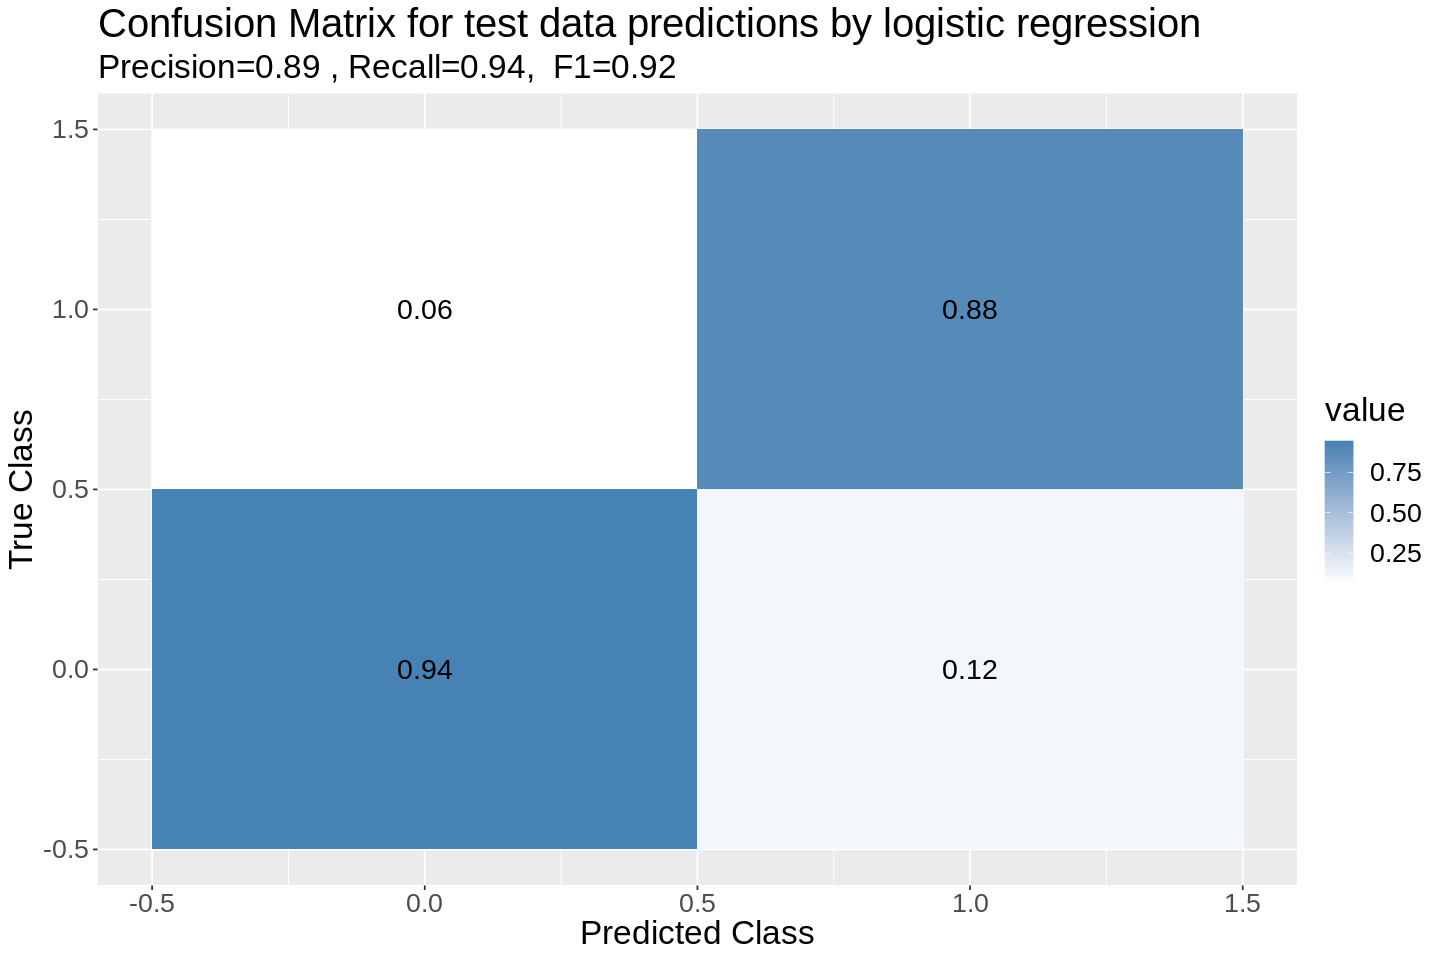

In [ ]:
# Visualize the quality metrics of test predictins

# Create a confusion matrix
confusion_matrix <- table(predictions, test.bin$class_bin)
normalized_matrix <- confusion_matrix / rowSums(confusion_matrix)

# Calculate the F1 score
precision <- confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[2,1])
recall <- confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,2])
f1_score <- 2 * (precision * recall) / (precision + recall)

ggplot(melt(normalized_matrix), aes(x=predictions, y=Var2, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +
  scale_fill_gradient(low="white", high="steelblue") +
  #theme(axis.text.x=element_text(angle=45, hjust=1)) +
  theme(legend.title = element_text(size = 20,), 
        text = element_text(size = 20),) +
  ggtitle("Confusion Matrix for test data predictions by logistic regression") +
  xlab("Predicted Class") +
  ylab("True Class") +
  labs(subtitle = sprintf("Precision=%.2f , Recall=%.2f,  F1=%.2f", 
                          precision,
                          recall, 
                          f1_score) )  

CONCLUSION:
- indeed the meteo- and geo- parameters define the wine groing potential of the area 

### Multinomial logistic regression

Let's consider a more difficult task of predicting the Winkler Index of an area around weather stations. 

At first we can try *multinomial* regression.

In [ ]:
vins_blancs

In [ ]:
unique(vins_rouges$cepage) 

[1] "raisins"            "Cabernet Franc"     "Cabernet Sauvignon" "Carignan"          
 [5] "Cinsaut"            "Gamay"              "Malbec "            "Mauzac Rose"       
 [9] "Merlot"             "Mourvèdre "         "Negrette"           "Pinot Noir"        
[13] "Syrah"

In [ ]:
train <- GDD_rainfall_wine.cls[GDD_rainfall_wine.cls$year <  2021 , c( "lat", "alt",  "GDD",  "GST", "cum_rainfall", "cepage")]
test  <- GDD_rainfall_wine.cls[GDD_rainfall_wine.cls$year == 2021,  c( "lat", "alt",  "GDD" , "GST", "cum_rainfall", "cepage")]

In [ ]:
library(caret)

# Fit a multi-class logistic regression model
tune_grid <- expand.grid(.decay=c(0, 0.1, 0.5, 1))
multinomial_LR <- train(cepage ~ ., data = train, method = "multinom" ,
                         tuneGrid=tune_grid, 
                         trace = FALSE)


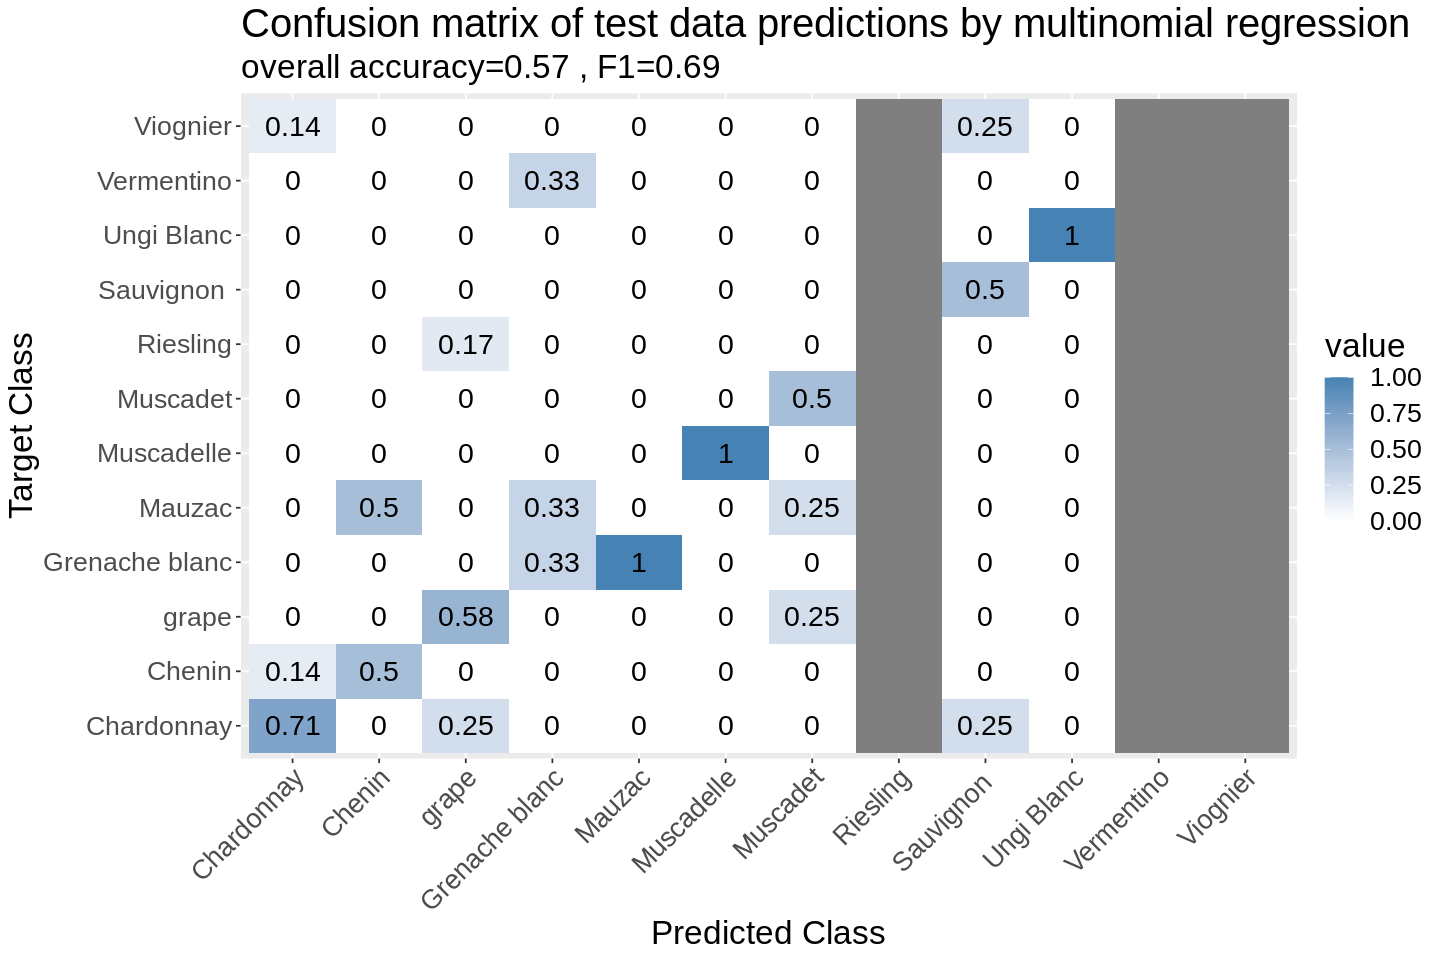

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

# Make predictions on the test set
predictions <- predict(multinomial_LR , test)

# Evaluate the model's performance
confusion_matrix  <- confusionMatrix(predictions, test$cepage, mode = "prec_recall")
normalized_matrix <- confusion_matrix$table / rowSums(confusion_matrix$table)

ggplot(melt(normalized_matrix), aes(x=Prediction, y=Reference, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +
  scale_fill_gradient(low="white", high="steelblue") +
  theme(axis.text.x=element_text(angle=45, hjust=1)) +
  theme(legend.title = element_text(size = 20,),  #face = "bold"
        text = element_text(size = 20),) +
  ggtitle("Confusion matrix of test data predictions by multinomial regression ") +
  xlab("Predicted Class") +
  ylab("Target Class") +
  labs(subtitle = sprintf("overall accuracy=%.2f , F1=%.2f", 
                          confusion_matrix$overall["Accuracy"], 
                          mean(confusion_matrix$byClass[, "F1"], na.rm=TRUE)) )

CONCLUSION:

- the multinomial logistic regression did not give us spectacular results

We can try other classification models though.

### Decision tree

To train a decision tree model we can either use the original implementation of the ```rpart```. This library implements recursive partitioning and is very easy to use. 

Or using the ```caret``` package we can just change the *method* parameter to train anoter type of model e.g. Decision Tree or Random Forest. WIth caret we can also easily specify the hyper-parameter for fine-tuning. 



#### Using ```rpart```

In [ ]:
library(rpart)

#rpart <- rpart(class~., data=train)
rpart <- rpart(cepage~., data=train)

In [ ]:
unique(train$cepage)

[1] grape          Riesling       Muscadelle     Chardonnay     Mauzac         Viognier      
 [7] Chenin         Sauvignon      Grenache blanc Muscadet       Vermentino     Ungi Blanc    
12 Levels: Chardonnay Chenin grape Grenache blanc Mauzac Muscadelle Muscadet ... Viognier

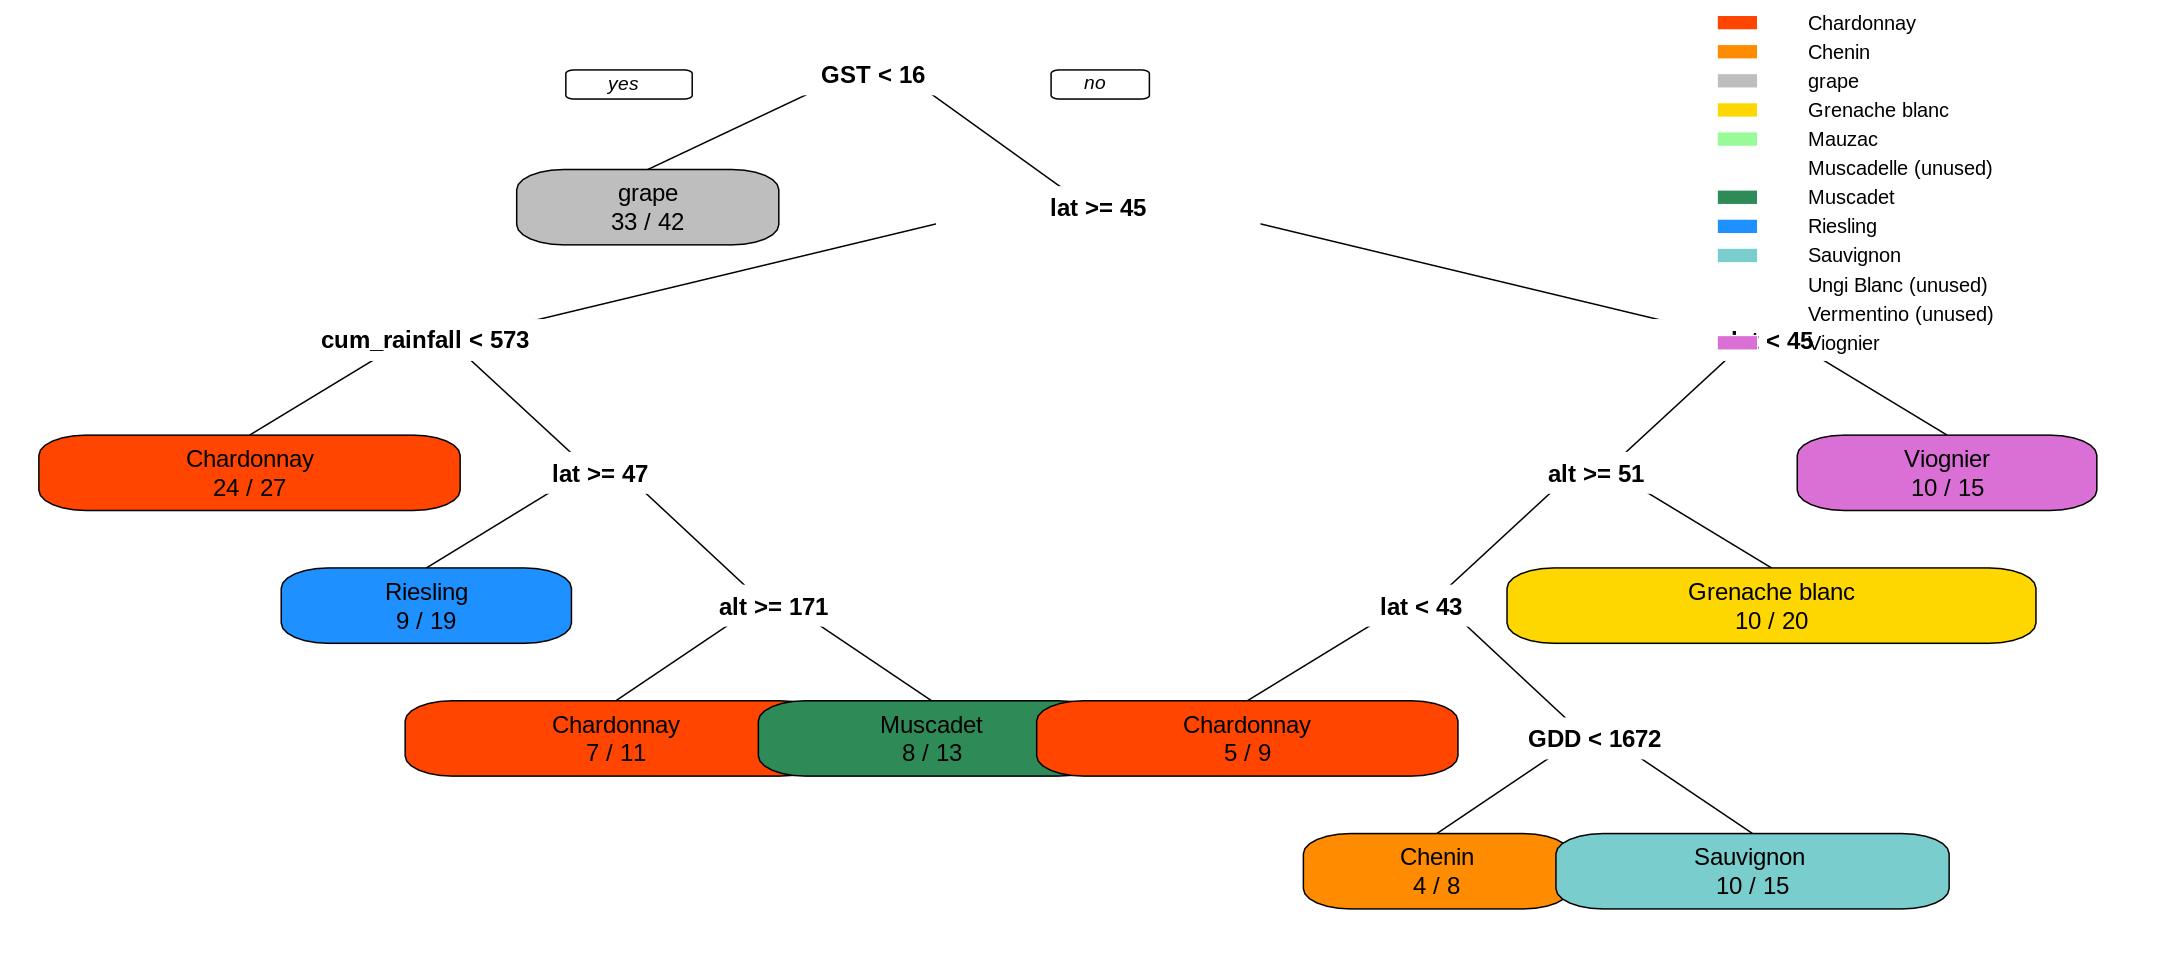

In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

region_colors= "auto"
blanc_colors <- list("orangered", "darkorange", "gray", "gold", "palegreen", "seagreen", "dodgerblue", "darkslategray3", "orchid", "hotpink", "maroon")


rpart.plot(rpart, 
          type=0, 
          extra=2,
          fallen.leaves=FALSE,
          cex=1.2,
          box.palette= blanc_colors)

#### Using ```caret```

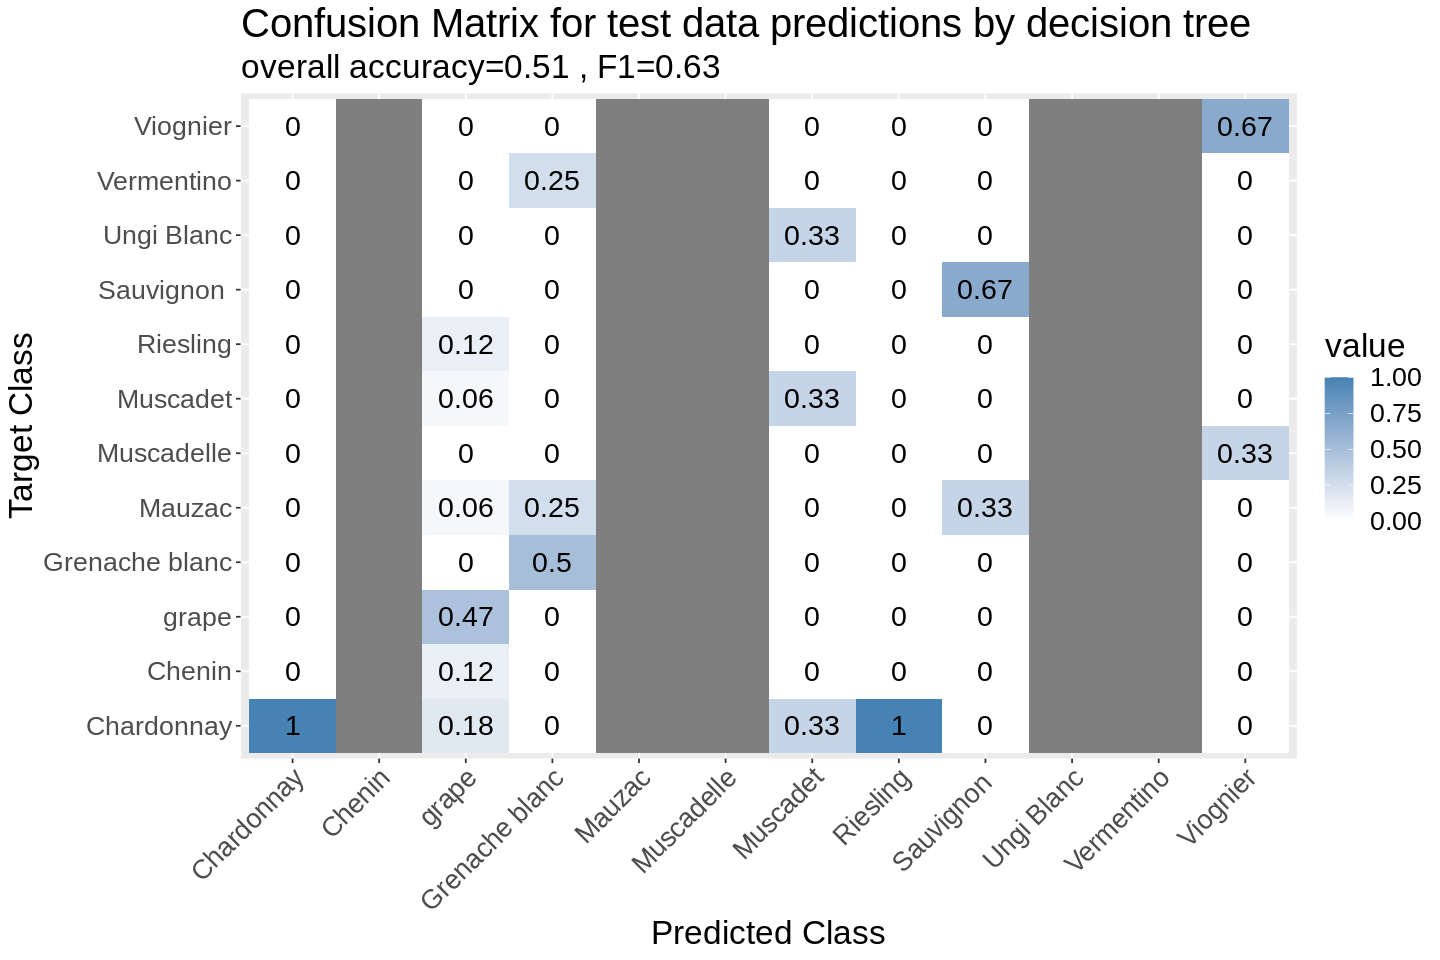

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

tune_grid <- expand.grid(.cp=c(0.01, 0.1, 1))
#tune_grid <- expand.grid(.maxdepth=c(2, 5, 10))

rpart <- train(cepage ~ ., data = train, method = "rpart", tuneGrid=tune_grid )

# Make predictions on the test set
predictions <- predict(rpart , test)

# Evaluate the model's performance
confusion_matrix  <- confusionMatrix(predictions, test$cepage, mode = "prec_recall")
normalized_matrix <- confusion_matrix$table / rowSums(confusion_matrix$table)

ggplot(melt(normalized_matrix), aes(x=Prediction, y=Reference, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +
  scale_fill_gradient(low="white", high="steelblue") +
  theme(axis.text.x=element_text(angle=45, hjust=1)) +
  theme(legend.title = element_text(size = 20,),  #face = "bold"
        text = element_text(size = 20),) +
   ggtitle("Confusion Matrix for test data predictions by decision tree") +
  xlab("Predicted Class") +
  ylab("Target Class") +
  labs(subtitle = sprintf("overall accuracy=%.2f , F1=%.2f", 
                          confusion_matrix$overall["Accuracy"], 
                          mean(confusion_matrix$byClass[, "F1"], na.rm=TRUE)) )

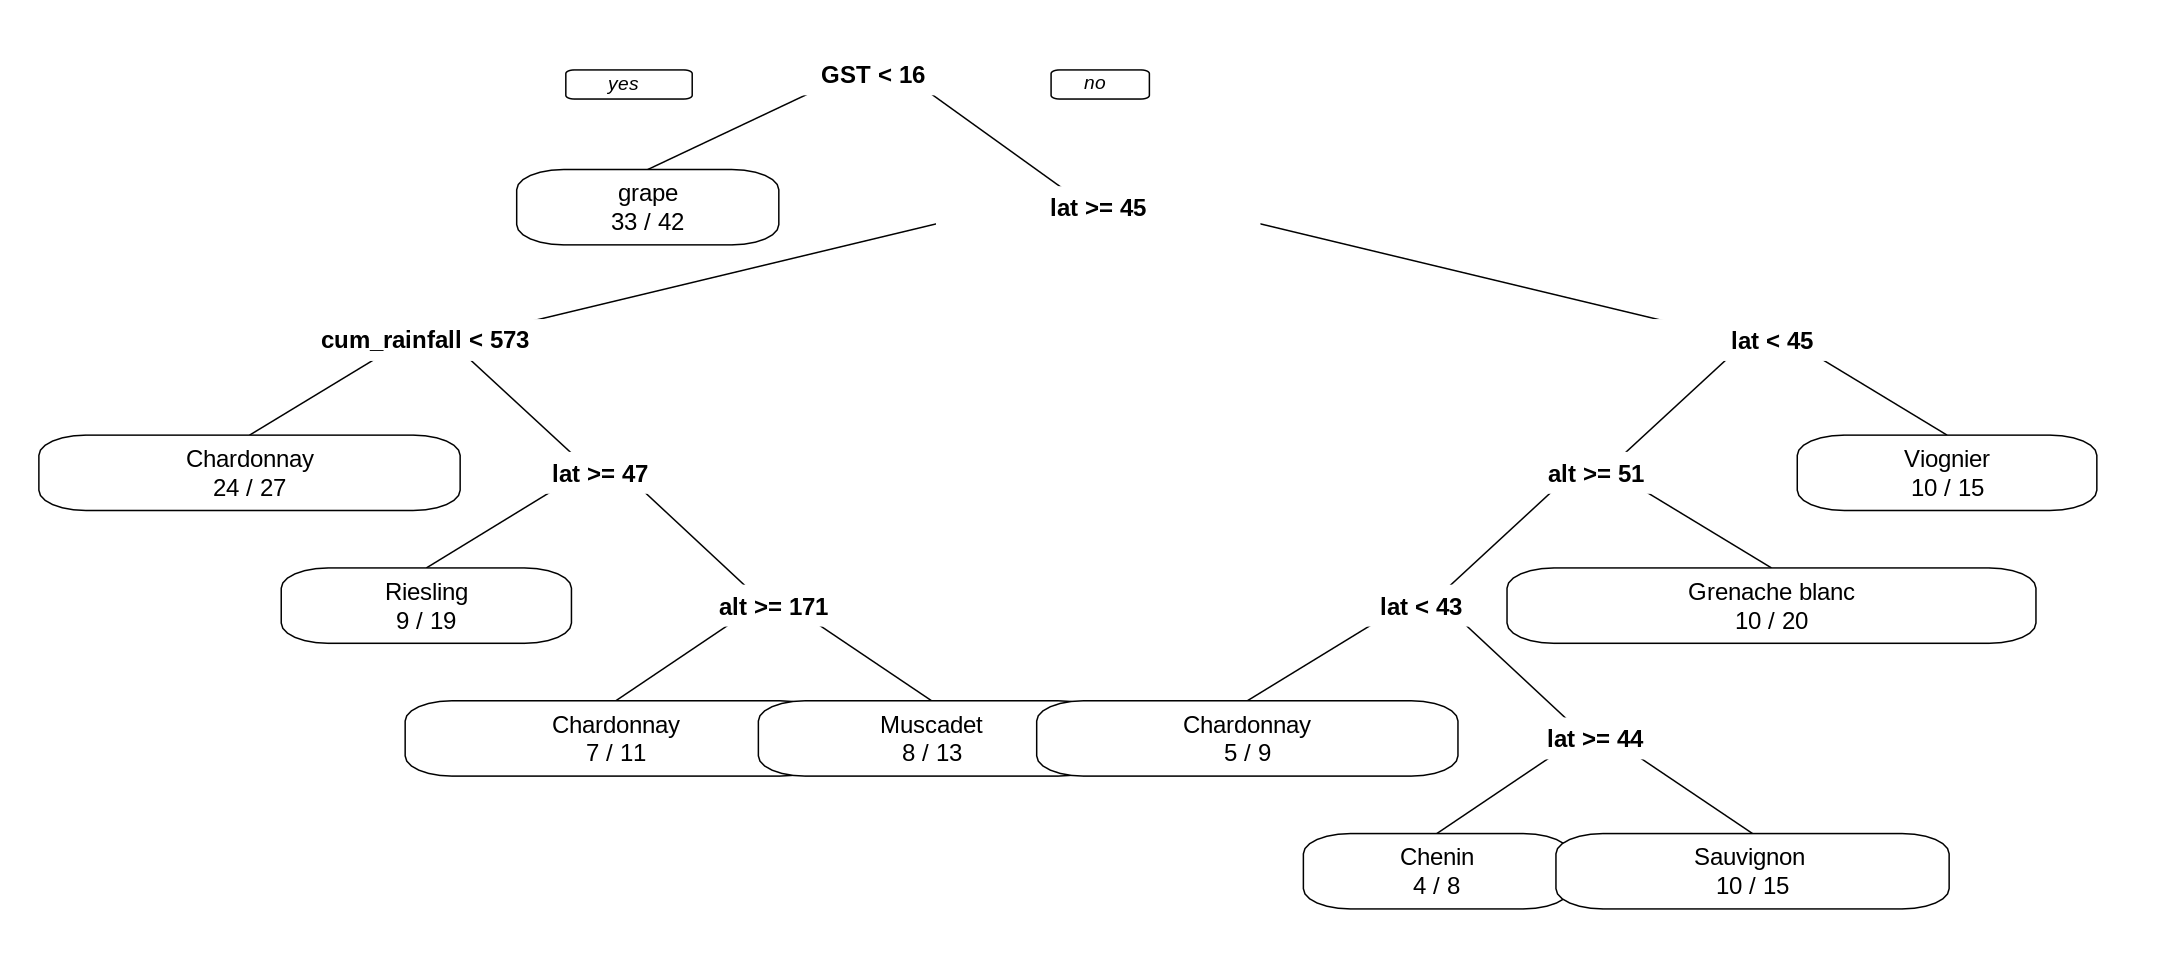

In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

rpart.plot(rpart$finalModel, 
          type=0,
          extra=2,
          fallen.leaves = FALSE,
          cex=1.2)

CONCLUSION:

- the fine-tuned decision tree algorithm uses only weather variables variables to build a pretty accurate predictive model of the area's Winkler Index, it ignores the geographical location **Why?**
- some odd confusions: "too hot" and "Region II **What and Why?**
- we can try other classifications models e.g. Random Forest by simply change the *model* parameter in *train* method of ```caret``` package

## Extend our dataset

The weather data we used so far connidered only the growing season of the Nothern hemisphere from April to October. What if we add some pre-growing season data like monthly percipitation and average soil temperature would we be able to better cluster the regions? 

In [ ]:
query_first_three_months  <- '
SELECT ?station ?stationName 
       ?year

       (SUM(?precipitation_jan) as ?rainfall_jan)
	   (SUM(?precipitation_feb) as ?rainfall_feb)
	   (SUM(?precipitation_mar) as ?rainfall_mar)

       (MIN(?soilTemp_jan) as ?minSoilTemp_jan)
	   (MIN(?soilTemp_feb) as ?minSoilTemp_feb)
	   (MIN(?soilTemp_mar) as ?minSoilTemp_mar)

WHERE
{
  ?station rdfs:label ?stationName;
           geo:lat ?lat.
  {
    ?obs a weo:MeteorologicalObservation;
         sosa:observedProperty wevp:precipitationAmount;
         sosa:hasSimpleResult ?precipitation;
         sosa:phenomenonTime [ a weo:Interval24h ];
         sosa:resultTime ?datetime;
         wep:madeByStation ?station. 

    FILTER (CONTAINS (STR(?datetime), "T00:00:00" ))
    BIND(MONTH(?datetime) AS ?month )
    FILTER  ( ?month < 4)
  
    BIND( IF(?month = 1, ?precipitation, 0) as ?precipitation_jan)
    BIND( IF(?month = 2, ?precipitation, 0) as ?precipitation_feb)
    BIND( IF(?month = 3, ?precipitation, 0) as ?precipitation_mar)
  }
  UNION
   {
      ?obs a weo:MeteorologicalObservation;
           sosa:observedProperty wevp:minSoilTemperature;
           sosa:hasSimpleResult ?soilTemp;
           sosa:phenomenonTime [ a weo:Interval12h ];
           sosa:resultTime ?datetime;
           wep:madeByStation ?station. 
    
    FILTER (CONTAINS (STR(?datetime), "T06:00:00" ))

    BIND(MONTH(?datetime) AS ?month )
    FILTER  ( ?month < 4)
  
    BIND( IF(?month = 1, ?soilTemp, 1000) as ?soilTemp_jan)
    BIND( IF(?month = 2, ?soilTemp, 1000) as ?soilTemp_feb)
  	BIND( IF(?month = 3, ?soilTemp, 1000) as ?soilTemp_mar)
  } 

  BIND(YEAR(?datetime) AS ?year )
   
  FILTER (?lat > 0) # only northern hemisphere
}

GROUP BY ?station ?stationName ?year 
ORDER BY ?stationName ?year 
'

query_first_three_months <- paste(sparql_prefix, query_first_three_months)

first_three_months <- SPARQL(url= endpoint,
              query = query_first_three_months,
              ns=data_prefix,
              extra=NULL)$results


print(paste('Result rows:', nrow(first_three_months)))

In [ ]:
merged_data <- merge(GDD_rainfall, first_three_months, by = c("station", "year"), all=TRUE)
print(paste('Merged rows:', nrow(merged_data)))

In [ ]:
merged_data.km <- na.omit(merged_data)
merged_data.labels <- paste0( merged_data.km$stationName.x, ".", merged_data.km$year)
merged_data.km <- merged_data.km[, c("lat", "long", "alt", "rainfall_jan","rainfall_feb", "rainfall_mar", "minSoilTemp_jan", "minSoilTemp_feb", "minSoilTemp_mar")]

#pca <- prcomp(GDD_rainfall.pca , center=TRUE,  scale.=TRUE)

#summary(pca)

#screeplot(pca)
#box()

# Perform the cluster analysis
k <- 7
km <- kmeans(scale(merged_data.km), k)

# View the cluster assignments for each data point
#print(km)

In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 12)
options(repr.plot.align = 'left')

rownames( data = merged_data.km) <- merged_data.labels

fviz_cluster(km, data = merged_data.km,
             #palette = c("#2E9FDF", "#00AFBB", "#E7B800"), 
             #geom = "point",
             ellipse.type = "t", 
             #ggtheme = theme_bw()
             )

## Principal Component Analisys (PCA)


In [ ]:
head(merged_data.km)

In [ ]:
# remove non-nummeric column and 
merged_data.pca <- na.omit(merged_data)
merged_data.pca <- merged_data.km[, c("lat", "long", "alt",  "rainfall_jan","rainfall_feb", "rainfall_mar",
                                                             "minSoilTemp_jan", "minSoilTemp_feb", "minSoilTemp_mar")]
#"GDD", "cum_rainfall",

In [ ]:
pca <- prcomp(merged_data.pca, center=TRUE,  scale.=TRUE)

In [ ]:
options(width=100)
summary(pca)
pca

In [ ]:
ncomp=4
rawLoadings     <- pca$rotation[,1:ncomp] %*% diag(pca$sdev, ncomp, ncomp)
#rotatedLoadings <- varimax(rawLoadings)$loadings
#invLoadings     <- t(pracma::pinv(rotatedLoadings))
#scores          <- scale(weather_data_all.wide.pca) %*% invLoadings
#print(scores[1:5,])

scores <- scale(pca$x[,1:ncomp]) %*% varimax(rawLoadings)$rotmat
print(scores[1:5,]) 
plot(scores[,1],scores[,2])


In [ ]:
screeplot(pca)

In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

biplot(pca,
       col=c('blue', 'red'),
       cex=c(0.8, 1.3),
       expand=1.2,
       #xlim= c(-0.1, 0.1), 
       #ylim= c(-0.1, 0.1),
       xlabs=merged_data.labels, 
       main='PCA Results')

In [ ]:
#install.packages("ggfortify")
library(ggfortify)

In [ ]:
autoplot(pca, loadings = TRUE,loadings.label = TRUE, loadings.label.size = 5, scale=0)